# Выбор локации для скважины

**Заказчик:** 

Добывающая компания «ГлавРосГосНефть».

___

**Цель:** 

Определение региона, где добыча принесёт наибольшую прибыль.

___

**Описание проекта:**

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.
Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.

___

**Задачи:** 
1. провести EDA;
1. построить три модели для каждого региона, определяющие в каком из них добыча принесет наибольшую прибыль;
1. выбрать скважины с самыми высокими значениями оценок;
1. определить возможную прибыль и риски техникой Bootstrap.

___

**Условия задачи:** 

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

___

**Описание данных:**

Данные геологоразведки трёх регионов находятся в файлах: 
- */datasets/geo_data_0.csv*
- */datasets/geo_data_1.csv*
- */datasets/geo_data_2.csv*
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

### Подключение библиотек

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

C:\Users\user\AppData\Local\Temp\ipykernel_16980\771646169.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling
C:\Users\user\AppData\Local\Temp\ipykernel_16980\771646169.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Загрузка данных

In [2]:
try:
    df_0 = pd.read_csv('geo_data_0.csv')
    df_1 = pd.read_csv('geo_data_1.csv')
    df_2 = pd.read_csv('geo_data_2.csv')
except:
    df_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Информация о данных

Отобразим информацию о данных.

In [3]:
dataframes = [df_0, df_1, df_2]

for i, df in enumerate(dataframes):
    df_name = f"Регион {i+1}"
    print('-'*40)
    print(f"{df_name}:")
    display(df.head(3))
    df.info()
    print(f"Количество явных дубликтов в {df_name}:", df.duplicated().sum())
    print(f"Столбец 'id' содержит", df['id'].duplicated().sum(), "дубликатов")
    
    duplicates = df[df.duplicated(subset='id', keep=False)] \
    .groupby('id')['product'] \
    .nunique() \
    .max()
    if duplicates > 0:
        max_duplicates = duplicates
    
    print(f"ID скважины встречается в датайфрейме максимальное количество раз': {max_duplicates}")
    print('-'*40)


----------------------------------------
Регион 1:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Количество явных дубликтов в Регион 1: 0
Столбец 'id' содержит 10 дубликатов
ID скважины встречается в датайфрейме максимальное количество раз': 2
----------------------------------------
----------------------------------------
Регион 2:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Количество явных дубликтов в Регион 2: 0
Столбец 'id' содержит 4 дубликатов
ID скважины встречается в датайфрейме максимальное количество раз': 2
----------------------------------------
----------------------------------------
Регион 3:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Количество явных дубликтов в Регион 3: 0
Столбец 'id' содержит 4 дубликатов
ID скважины встречается в датайфрейме максимальное количество раз': 2
----------------------------------------


В каждой таблице по 100000 строк. Пропусков нет, явные дубликаты отсутствуют. Но в  каждом датасете встречаются не явные дубликаты. Возможно произошла какая-то техническая неисправность при передачи данных со стороны заказчика, об этом баге ему стоит сообщить.

Доля таких дубликатов не более 0.1% - такой объем не исказит результаты нашего исследования.

Удалим столбец `id`, чтобы сделать датафреймы менее шумным.

In [4]:
for i, df in enumerate(dataframes):
    i = df.drop('id', axis=1, inplace=True)

#### Корреляционные матрицы.

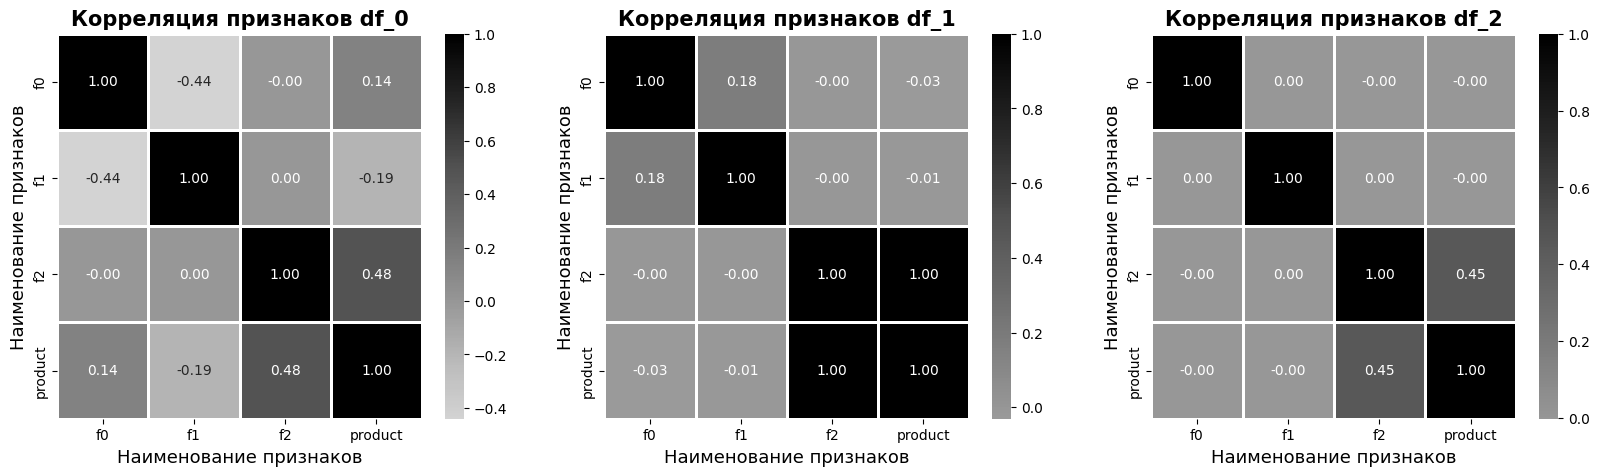

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, df in enumerate(dataframes):
    ax = axes[i]
    title = f'Корреляция признаков df_{i}'    
    sns.heatmap(df.corr(),
                annot=True,
                fmt='.2f',
                linewidth=1,
                linecolor='white',
                vmax=1,
                center=0,
                cmap='Greys',
                ax=ax)
    
    ax.set_title(title, size=15, fontweight="bold")
    ax.set_xlabel('Наименование признаков', size=13)
    ax.set_ylabel('Наименование признаков', size=13)
    
    #pd.plotting.scatter_matrix(df, alpha=.01)
    
plt.show()

По второму региону видим прямую (положительную) корреляцию признака `f2` с целевой переменной `product`, в остальных случаях корреляция слабая или ее нет вовсе.

#### Матрицы рассеяния

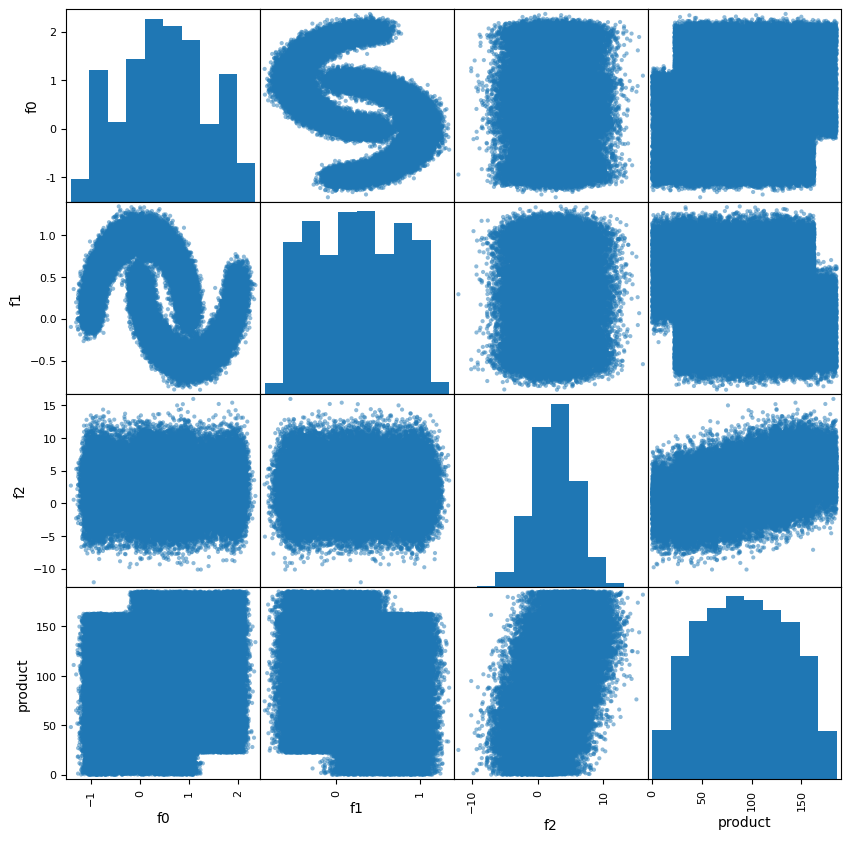

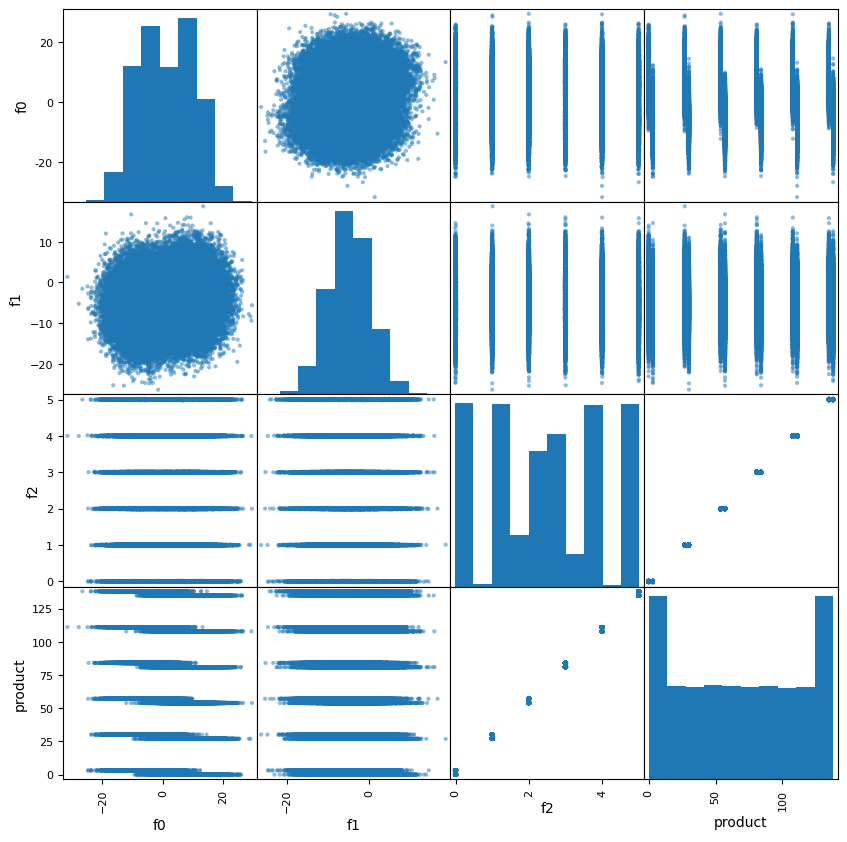

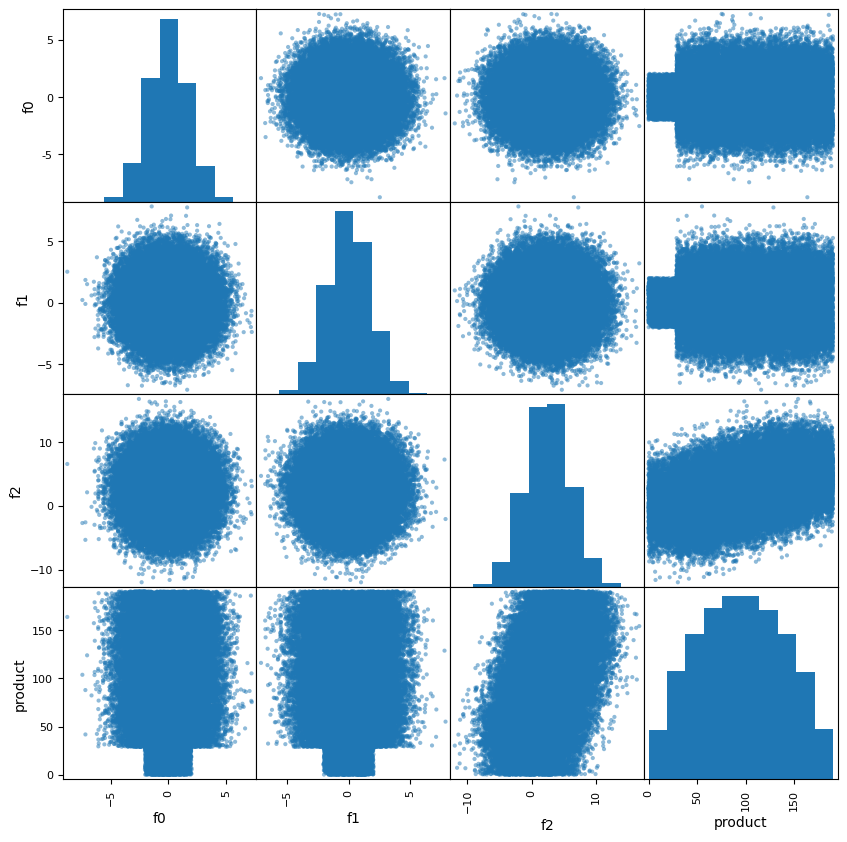

In [6]:
for i, df in enumerate(dataframes):
    pd.plotting.scatter_matrix(df,figsize=(10, 10), alpha=0.5, diagonal='hist')
    plt.show()

#### Гистограмма распределения признаков

In [7]:
col = df_0.columns.to_list()

def plot_histograms(df, n):
    _, axs = plt.subplots(1, len(col), figsize=(24, 4))

    for i in range(len(col)):
        axs[i].hist(df[col[i]], bins=50)
        axs[i].set_xlabel(f'Признак {col[i]}')
        axs[i].set_ylabel("Количество значений")
        axs[i].grid(True)
    plt.suptitle(f'Гистограммы распределения признаков в регионе №{n+1}')
    plt.show()

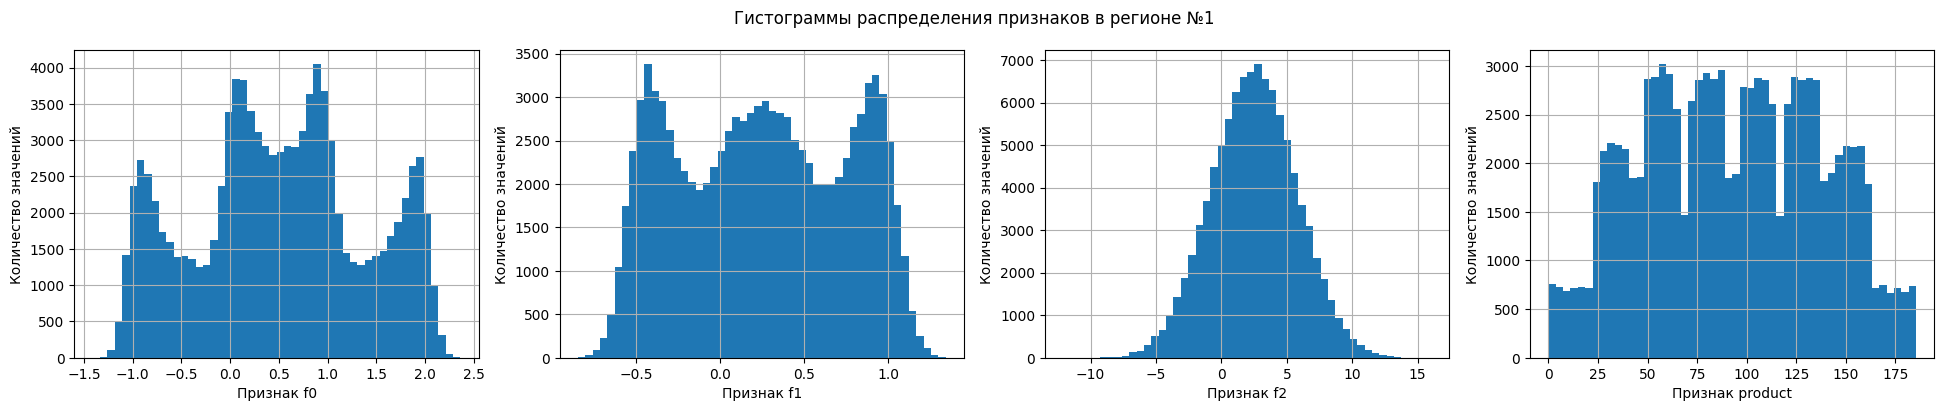

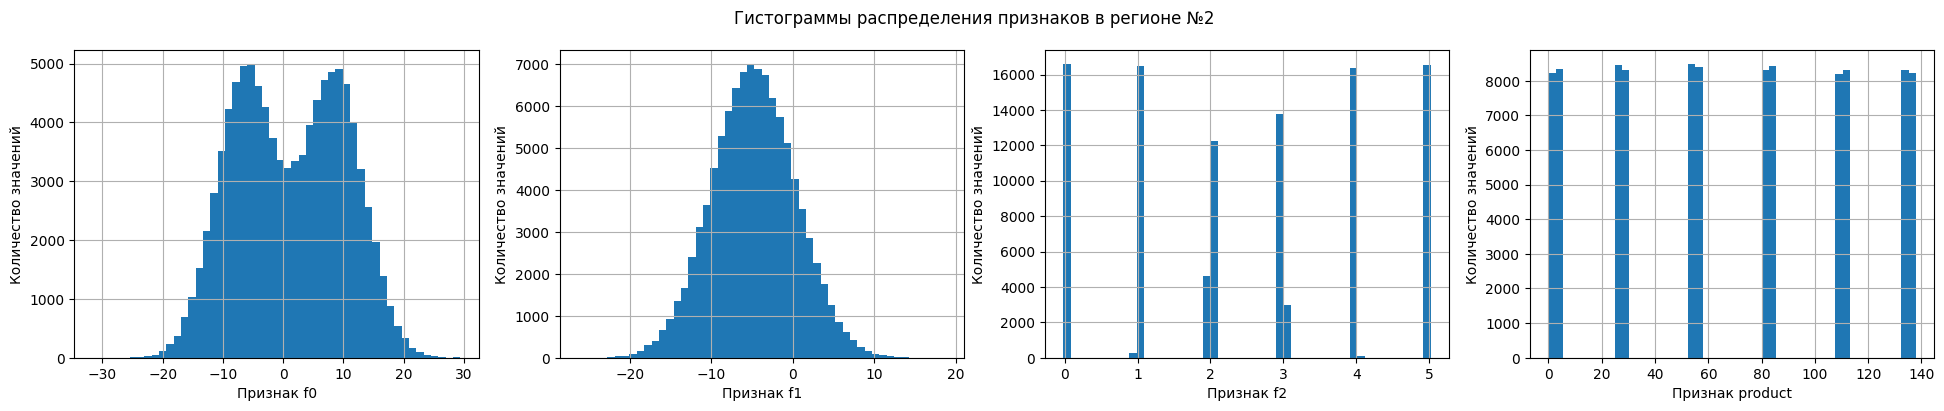

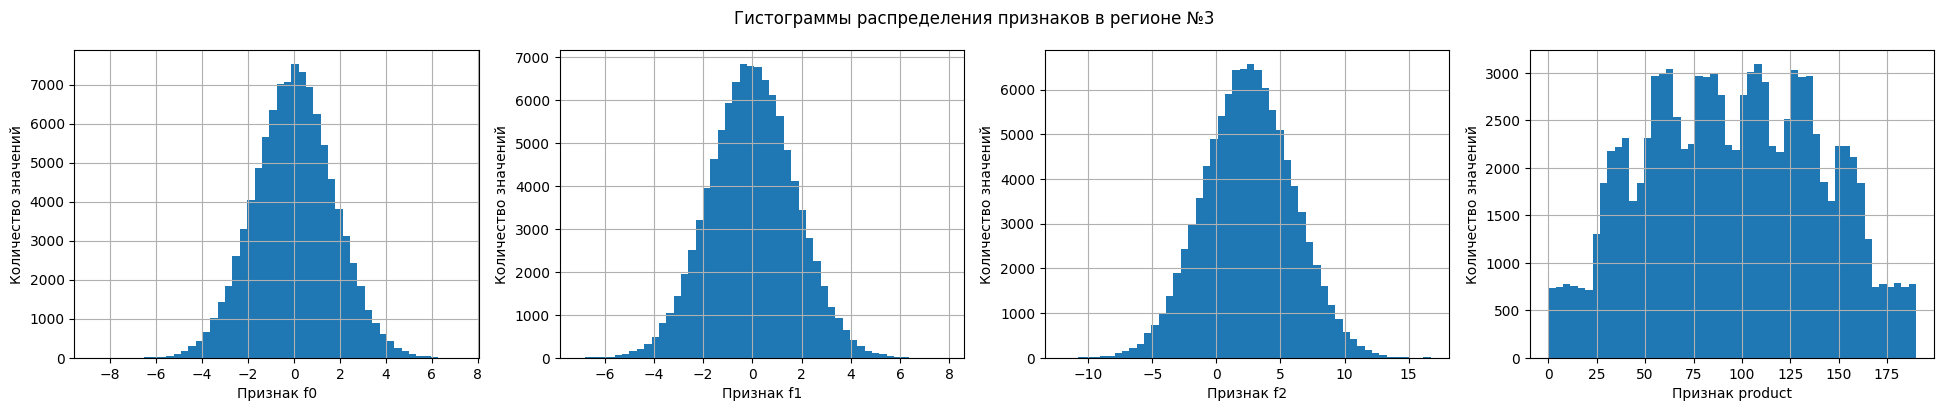

In [8]:
for i, df in enumerate(dataframes):
    plot_histograms(df, i)

#### Вывод

По построенным гистограммам видно, что рассматриваемые признаки имеют различные диапазоны значений от региона к региону. При этом, только в регионе №3 у всех трех признаков наблюбдается нормальное распределение. Признаки `f2` и `product` во втором регионе имеет высокую корреляцию, которую видно на матрице корреляций, матрице и гистограмме рассеяния. Т.к. природу данных признаков мы не знаем, то и удалять их не стоит, несмотря на негативное влияние мультиколлинеарности на качество моделей. 

### Подготовка выборок

Функция деления датасета на выборки

In [9]:
def train_valid_split(df):
    features = df.drop(columns='product', axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=.25,
        random_state=23)
    
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.fit_transform(features_valid)
    
    return features_train, features_valid, target_train, target_valid

Применяем функцию к каждому датасету

In [10]:
(features_train_0, 
features_valid_0, 
 target_train_0, 
 target_valid_0) = train_valid_split(df_0)

(features_train_1, 
features_valid_1, 
 target_train_1, 
 target_valid_1) = train_valid_split(df_1)

(features_train_2, 
features_valid_2, 
 target_train_2, 
 target_valid_2) = train_valid_split(df_2)

## Обучение и проверка модели

Напишем функцию, возвращающую RMSE и средний объем сырья.

In [11]:
def rmse(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    mean_predict = predicted_valid.mean()
    rmse = mean_squared_error(target_valid, predicted_valid, squared=False)
    print('Средний запас предсказанного сырья:', mean_predict)
    print('RMSE:', rmse)
    return predicted_valid, mean_predict

### Рассчет RSME и среднего запаса по регионам

In [15]:
for i in range(3):
    print(f'Регион {i+1}')
    exec(f"predict_target_{i}, mean_predict_{i} = rmse(features_train_{i}, features_valid_{i}, target_train_{i}, target_valid_{i})")
    print('\n')

Регион 1
Средний запас предсказанного сырья: 92.51606156959983
RMSE: 37.91368536422668


Регион 2
Средний запас предсказанного сырья: 68.78996352509604
RMSE: 0.912982480442497


Регион 3
Средний запас предсказанного сырья: 94.93417679974382
RMSE: 40.207631886747265




### Вывод

Во втором регионе метрика RMSE стремится к нулю. На это влияет мультиколлинеарность. В двух других регионах показатели похожи между собой: показывают большую стандартную ошибку и больший средний запас предсказанного сырья, относительно второго региона.

## Подготовка к расчёту прибыли

### Ключевые значения для расчётов

In [16]:
POINT = 500
BEST_POINT = 200
BUDGET = 10**10
INCOME_PER_BARREL = 450
INCOME_PER_PRODUCT = INCOME_PER_BARREL * 1000

Посчитаем безубыток

In [17]:
MIN_VOLUME = BUDGET / BEST_POINT / INCOME_PER_PRODUCT
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {MIN_VOLUME:.2f}')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11


Средние запасы предсказанного сырья в каждом регионе меньше, чем достаточный объём сырья для безубыточной разработки.

### Функция для расчёта прибыли

In [18]:
def income(predictions, target):
    best_predict = pd.Series(predictions).sort_values(ascending=False).head(BEST_POINT)
    points = target.iloc[best_predict.index]
    income = (INCOME_PER_PRODUCT * points.sum()) - BUDGET
    return income

### Функция для расчёта рисков и прибыли для каждого региона

In [23]:
def bootstrap_income(predictions, target, region):
    state = np.random.RandomState(23)
    values = []
    
    for i in range(1000):
        subsample = pd.Series(predictions).sample(n=500, random_state=state, replace=True)
        values.append(income(subsample, target.reset_index(drop=True)))
        
    values = pd.Series(values)
    mean_income = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = (values < 0).mean()
    
    # Гистограмма
    plt.hist(values, bins=30, edgecolor='black', alpha=0.5)
    
    # Отметка средней прибыли
    plt.axvline(mean_income, color='red', linestyle='dashed', linewidth=2, label='Средняя прибыль')
    
    # Отметки доверительного интервала
    plt.axvline(lower, color='green', linestyle='dotted', linewidth=2, label='95%-й доверительный интервал')
    plt.axvline(upper, color='green', linestyle='dotted', linewidth=2)
    
    plt.xlabel('Прибыль')
    plt.ylabel('Частота')
    plt.title(region)
    plt.legend()
    plt.show()
    
    #print(region)
    print('Средняя прибыль с региона:', round(mean_income / 10**6, 1), 'млн.')
    print('95%-й доверительный интервал от', round(lower / 10**6, 1),'до', round(upper / 10**6, 1))
    print('Вероятность убытков {:.2%}'.format(risk))
    print('-'*40)

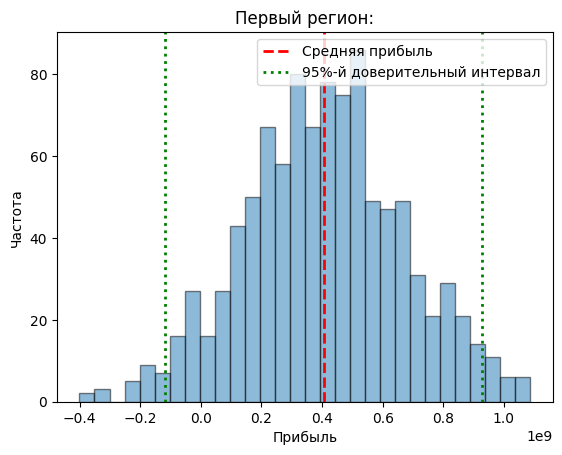

Средняя прибыль с региона: 405.7 млн.
95%-й доверительный интервал от -118.8 до 926.9
Вероятность убытков 7.00%
----------------------------------------


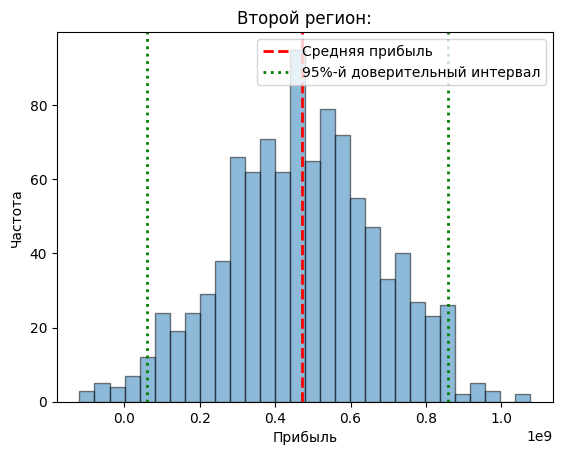

Средняя прибыль с региона: 470.7 млн.
95%-й доверительный интервал от 61.1 до 858.7
Вероятность убытков 1.20%
----------------------------------------


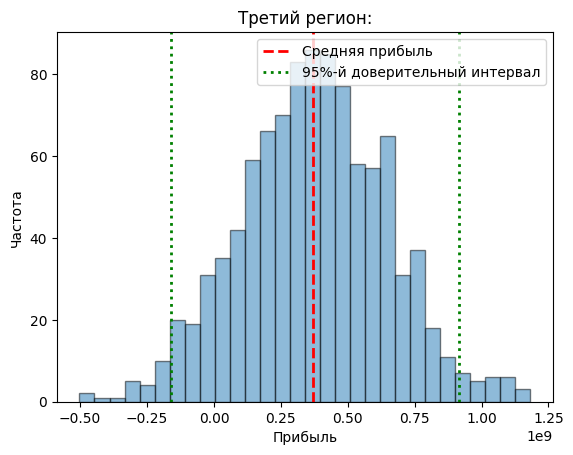

Средняя прибыль с региона: 371.7 млн.
95%-й доверительный интервал от -160.0 до 916.7
Вероятность убытков 8.90%
----------------------------------------


In [24]:
bootstrap_income(predict_target_0, target_valid_0, 'Первый регион:')
bootstrap_income(predict_target_1, target_valid_1, 'Второй регион:')
bootstrap_income(predict_target_2, target_valid_2, 'Третий регион:')

## Вывод

В ходе исследования на предмет выбора локации для скважины выявили среднюю прибыль, 95%-й доверительный интервал и вероятность убытков с каждого региона. На основе полученных данных, рекомендуется выбрать **второй регион**:
 - Средняя прибыль с этой локации будет достигать 470 млн (против 405 - с первой, 370 - с третьей)
 - 95%-й доверительный интервал располагается только в положительных значениях, относительно двух других регионов
 - Вероятность убытков, в случае бурения скважины во втором регионе, состовляет всего 1.2%. В первом регионе этот показатель равен 7%, в третьем - 9%.